In [ ]:
import sympy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.integrate import simpson, quad
from scipy.special import spherical_jn
import torch

import warnings
warnings.filterwarnings("ignore")

# Constants

In [3]:
# Pb-208
R = 6.65
a = 0.526
Z = 82
# Au
R1 = 6.63
a1 = 0.45
Z1 = 79
hbarc = 197.327 # MeV fm
# ----------------
E1 = 126 # MeV
E2 = 183 # MeV
e_constant = 18.095 # e^2 / ε0 MeV fm

## Charge Density Distribution

In [4]:
def rho_dist(r,rho0,R,a):
    return rho0 / (1 + np.exp((r - R) / a))

## Normalization

In [5]:
# Spherical integration (r^2 dr dΩ)
def normalized_rho_dist(R, a, Z):
    
    # Integrand for normalization calculation
    def integrand(r):
        return 4 * np.pi * r**2 * rho_dist(r, 1.0,R,a)  # Using rho0=1 temporarily
    
    # Calculate normalization integral
    I_result, _ = quad(integrand, 0, np.inf)
    
    # Compute normalization constant
    rho0_val = Z / I_result
    
    # Create normalized function
    def norm_rho_dist(r):
        return rho_dist(r, rho0_val,R,a)
    
    return norm_rho_dist, rho0_val

rho_norm, rho0 = normalized_rho_dist(R,a,Z)

# Verification prints
print(f"Normalization constant ρ0 = {rho0:.6f} e/fm^3")

# Verify integral equals Z
integral = quad(lambda r: 4*np.pi*r**2*rho_norm(r), 0, np.inf)[0]
print(f"Verification: Integral of normalized ρ_dist = {integral:.2f} (should be {Z})\n")

# Check characteristic points
print(f"ρ(R) = {rho_norm(6.63):.6f} e/fm^3 (should be ρ0/2 = {rho0/2:.6f})")
print(f"ρ(0) = {rho_norm(0):.6f} e/fm^3 (maximum density)")
print(f"ρ(2R) = {rho_norm(2*6.63):.6f} e/fm^3 (far tail)")

Normalization constant ρ0 = 0.062696 e/fm^3
Verification: Integral of normalized ρ_dist = 82.00 (should be 82)

ρ(R) = 0.031944 e/fm^3 (should be ρ0/2 = 0.031348)
ρ(0) = 0.062696 e/fm^3 (maximum density)
ρ(2R) = 0.000000 e/fm^3 (far tail)


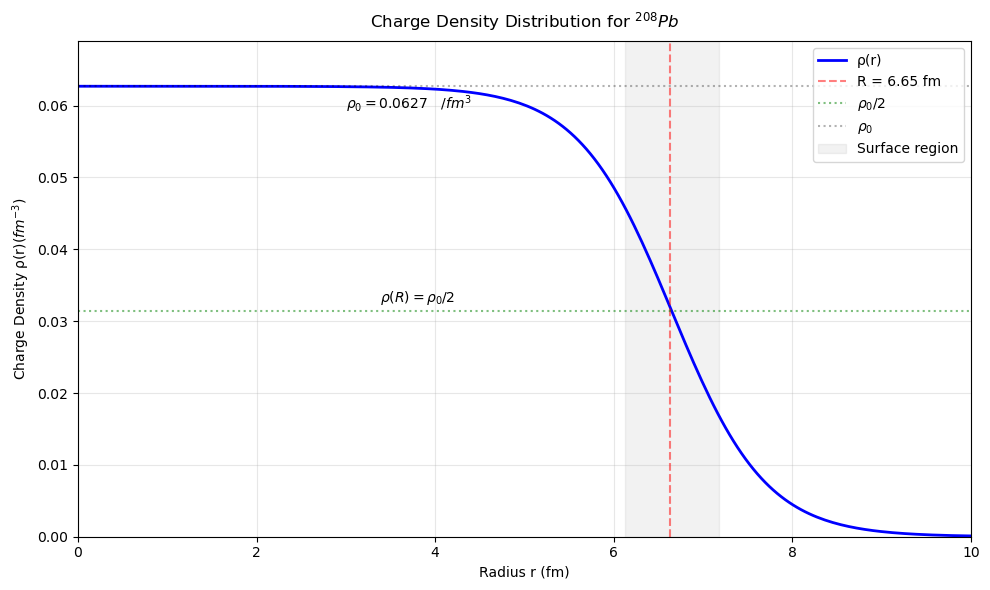

In [6]:
plt.figure(figsize=(10, 6))

# Generate radial points (0 to 3R for good visualization)
r_values = np.linspace(0, 2*R, 300)
rho_values = rho_norm(r_values)


plt.plot(r_values, rho_values, 'b-', linewidth=2, label='ρ(r)')
plt.axvline(6.63, color='r', linestyle='--', alpha=0.5, label=f'R = {R} fm')
plt.axhline(rho0/2, color='g', linestyle=':', alpha=0.5, label=r'$\rho_0/2$')
plt.axhline(rho0, color='k', linestyle=':', alpha=0.3, label=r'$\rho_0$')

# surface diffuseness region
plt.axvspan(R-a, R+a, color='gray', alpha=0.1, label='Surface region')
plt.title(r'Charge Density Distribution for $^{208}Pb$', pad=10)
plt.xlabel('Radius r (fm)')
plt.ylabel(r'Charge Density ρ(r)($fm^{-3}$)')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.xlim(0, 10)
plt.ylim(0, rho0*1.1)
plt.text(3.8, rho0*0.51, r'$\rho(R) = \rho_0/2$', ha='center', va='bottom')
plt.text(3, rho0*0.95, fr'$\rho_0 = {rho0:.4f} \quad /fm^3 $', ha='left')
plt.tight_layout()
plt.show()

## Compute main integral

q [/fm]	F(q)
0.00		81.921160
0.06		80.382753
0.12		75.899583
0.18		68.852114
0.24		59.824449
0.31		49.536916
0.37		38.765552
0.43		28.259567
0.49		18.667589
0.55		10.481635
0.61		4.004578
0.67		-0.656919
0.73		-3.575773
0.80		-4.969103
0.86		-5.151082
0.92		-4.481762
0.98		-3.319111
1.04		-1.979950
1.10		-0.713335
1.16		0.312416
1.22		1.009997
1.29		1.363210
1.35		1.410339
1.41		1.224478
1.47		0.894112
1.53		0.506484
1.59		0.135327
1.65		-0.166452
1.71		-0.369339
1.78		-0.465838
1.84		-0.466307
1.90		-0.393221
1.96		-0.275029
2.02		-0.140550
2.08		-0.014564
2.14		0.085049
2.20		0.148518
2.27		0.173921
2.33		0.165778
2.39		0.132939
2.45		0.086236
2.51		0.036305
2.57		-0.008096
2.63		-0.041096
2.69		-0.060026
2.76		-0.065116
2.82		-0.058777
2.88		-0.044681
2.94		-0.026851
3.00		-0.008918


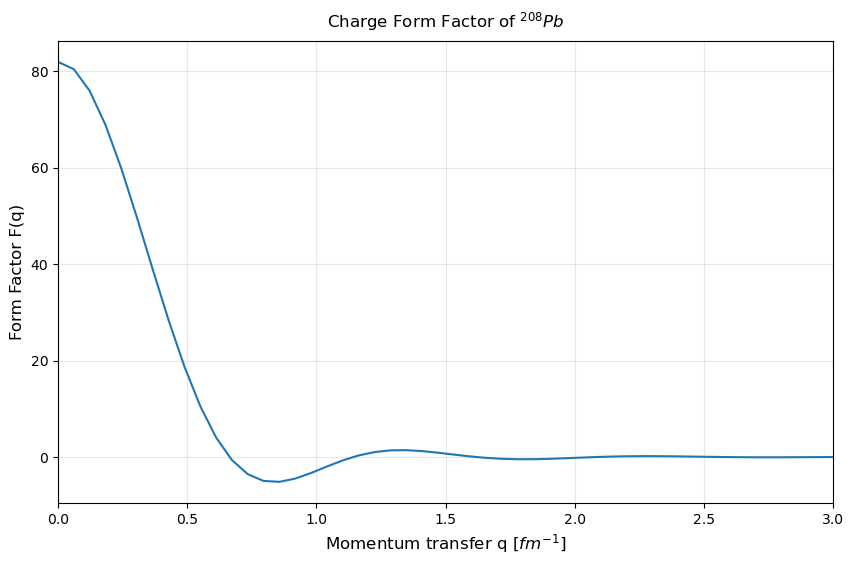

In [7]:
def rho_ch(r, R=R, a=a, Z=Z):
    # Calculate normalization constant ρ0
    def integrand(r):
        return 4 * np.pi * r**2 / (1 + np.exp((r - R)/a))
    integral, _ = quad(integrand, 0, np.inf)
    rho0 = Z / integral
    return rho0 / (1 + np.exp((r - R)/a))

def form_factor(q, r_max=10.0):
    def integrand(r):
        return 4 * np.pi * r**2 * rho_ch(r) * spherical_jn(0, q*r)
    result, _ = quad(integrand, 0, r_max)
    return result



q_values = np.linspace(0, 3, 50)  # q-range [fm^-1]
Fq_values = [form_factor(q) for q in q_values]

print("q [/fm]\tF(q)")
for q, Fq in zip(q_values, Fq_values):
    print(f"{q:.2f}\t\t{Fq:.6f}")

plt.figure(figsize=(10, 6))
plt.plot(q_values, Fq_values)
plt.xlabel(r'Momentum transfer q [$fm^{-1}$]', fontsize=12)
plt.ylabel('Form Factor F(q)', fontsize=12)
plt.title(r'Charge Form Factor of $^{208}Pb$', pad=10)
plt.xlim(0,3)
plt.grid(True, alpha=0.3)
plt.show()

Text(0.5, 1.0, 'Cross-Section of $^{197}Au$')

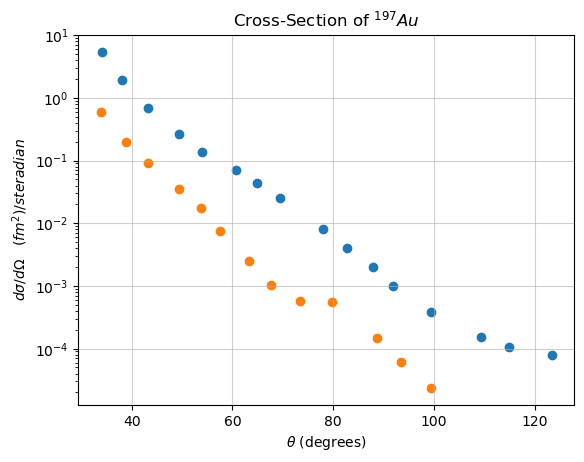

In [8]:
dataset = pd.read_csv("cross_section_data.csv")
data1 = dataset[dataset["E"] == 126]
data2 = dataset[dataset["E"] == 183]

plt.figure()
plt.scatter(data1["deg"],data1["cs"])
plt.scatter(data2["deg"],data2["cs"])
plt.yscale('log')
plt.grid(alpha=0.6)
plt.xlabel(r"$\theta$ (degrees)")
plt.ylabel(r"$d\sigma /d\Omega \quad(fm^2)/steradian$")
plt.title(r"Cross-Section of $^{197}Au$")

In [9]:

def calculate_cs(Z, R, a, E, theta, hbarc=hbarc):
    # Normalization constant
    rho0 = normalized_rho_dist(R, a, Z)[1]
    q = 2 * E * np.sin(theta/2) / hbarc
    const = (2*np.pi)**2 * E**2 * (1/(hbarc))**2 * (1/q)**4 * 4*a**2

    # Simpson integration grid
    r = np.linspace(0.1, 15, 2000)
    integrand = rho_dist(r, rho0, R, a) * r**2 * 2 * np.sin(q*r) / (q*r)
    result = simpson(integrand, r)

    result = const * result**2
    return result

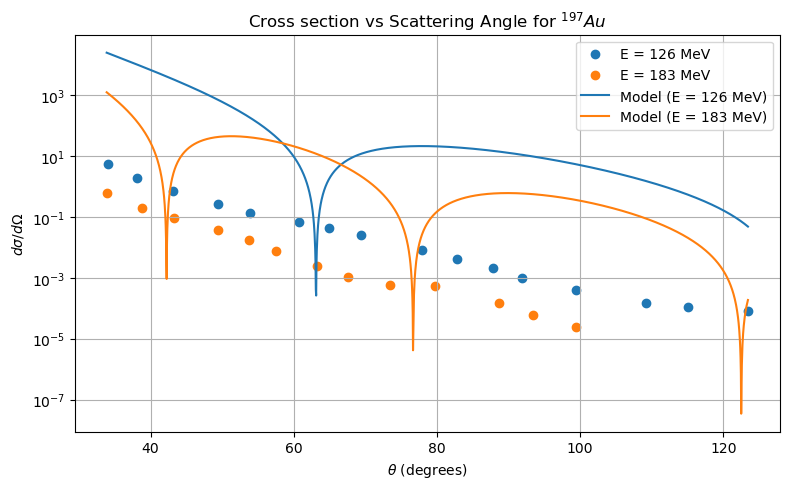

In [10]:
deg = np.linspace(min(dataset["deg"]), max(dataset["deg"]), 2000) 
deg_rad = np.radians(deg)

plt.figure(figsize=(8, 5))

plt.scatter(data1["deg"],data1["cs"],label="E = 126 MeV")
plt.scatter(data2["deg"],data2["cs"],label="E = 183 MeV")
csv_data = []

for E in [126,183]:
    cross_sections = []
    for theta in deg_rad:
        sigma = calculate_cs(Z=Z1, R=R1, a=a1, E=E, theta=theta)
        cross_sections.append(sigma)
        theta = np.degrees(theta)
        csv_data.append([theta, sigma, E])
    plt.plot(deg, cross_sections, label=f"Model (E = {E} MeV)")

plt.yscale('log')
plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel(r'$d\sigma/d\Omega$')
plt.title(r'Cross section vs Scattering Angle for $^{197}Au$')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

df = pd.DataFrame(csv_data, columns=['deg', 'cs', 'E'])
#df.to_csv('cross_sections_calculated.csv', index=False)

# PyTorch 
## ```R``` and ```a``` pairs tuning

## Function change

In [57]:
def calculate_cs_torch(R, a, theta, Z=79, E=183, hbarc=197.327):
    # Clamp R and a to prevent nonphysical or unstable values
    R = torch.clamp(R, 5.0, 12.0)
    a = torch.clamp(a, 0.05, 1.5)

    # Compute q
    q = 2 * E * torch.sin(theta / 2) / hbarc

    # Integration grid
    r = torch.linspace(0.1, 15, 1000)
    dr = r[1] - r[0]

    # Unnormalized density
    exp_arg = (r - R) / a
    exp_arg = torch.clamp(exp_arg, -60.0, 60.0)  # Prevent overflow
    rho_unnorm = 1.0 / (1.0 + torch.exp(exp_arg))

    integral = torch.sum(4 * np.pi * r**2 * rho_unnorm * dr)
    rho0 = Z / integral

    # Normalized density
    rho_r = rho0 / (1.0 + torch.exp(exp_arg))

    # Form factor integral
    sinc_arg = q * r
    sinc_arg = torch.where(sinc_arg == 0, torch.tensor(1e-6), sinc_arg)  # Avoid div by 0
    form_integrand = rho_r * r**2 * (2 * torch.sin(sinc_arg) / sinc_arg)
    form_factor = torch.sum(form_integrand * dr)

    const = (2*np.pi)**2 * E**2 * (1/hbarc)**2 * (1/q)**4 * 4 * a**2
    return const * form_factor**2


## Data preprocessing

In [ ]:
exp_data = pd.read_csv("cross_section_data.csv")
theta_exp_deg = exp_data['deg'].values
theta_exp_rad = np.radians(theta_exp_deg)
cs_exp = exp_data['cs'].values

In [ ]:
theta_tensor = torch.tensor(theta_exp_rad, dtype=torch.float32)
cs_exp_tensor = torch.tensor(cs_exp, dtype=torch.float32)

## Model training

In [66]:
# Prepare data_by_E from data1 and data2
data_by_E = {
    126: (data1["deg"].values, data1["cs"].values),
    183: (data2["deg"].values, data2["cs"].values)
}

results = {}
energy_values = [126, 183]


for E in energy_values:
    # Get experimental data for this energy (in degrees)
    theta_exp_deg = data_by_E[E][0]
    cs_exp = data_by_E[E][1]
    
    # Create torch tensors (convert angles to radians)
    theta_tensor = torch.tensor(np.radians(theta_exp_deg), dtype=torch.float32)
    cs_exp_tensor = torch.tensor(cs_exp, dtype=torch.float32)
    
    # Fresh start for parameters for this energy
    R_param = torch.tensor([R1], dtype=torch.float32, requires_grad=True)
    a_param = torch.tensor([a1], dtype=torch.float32, requires_grad=True)
    optimizer = torch.optim.Adam([R_param, a_param], lr=0.01)
    
    epoch_losses = []
    epochs = 15000
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        preds = torch.stack([calculate_cs_torch(R_param, a_param, t, E=E) for t in theta_tensor])
        loss = torch.mean((preds - cs_exp_tensor)**2)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        
        if epoch % 50 == 0:
            print(f"Energy {E} MeV: Epoch {epoch:4d} | Loss = {loss.item():.6f} | R = {R_param.item():.4f}, a = {a_param.item():.4f}")
    
    results[E] = {
        'R': R_param.item(),
        'a': a_param.item(),
        'loss_history': epoch_losses
    }

Energy 126 MeV: Epoch   50 | Loss = 472983.000000 | R = 6.8906, a = 0.1452
Energy 126 MeV: Epoch  100 | Loss = 92440.132812 | R = 6.9093, a = 0.0974
Energy 126 MeV: Epoch  150 | Loss = 37451.863281 | R = 6.9136, a = 0.0778
Energy 126 MeV: Epoch  200 | Loss = 18613.789062 | R = 6.9158, a = 0.0654
Energy 126 MeV: Epoch  250 | Loss = 10486.182617 | R = 6.9171, a = 0.0567
Energy 126 MeV: Epoch  300 | Loss = 6442.650879 | R = 6.9180, a = 0.0502
Energy 126 MeV: Epoch  350 | Loss = 6260.227051 | R = 6.9186, a = 0.0489
Energy 126 MeV: Epoch  400 | Loss = 6255.597656 | R = 6.9193, a = 0.0489
Energy 126 MeV: Epoch  450 | Loss = 6250.600098 | R = 6.9201, a = 0.0489
Energy 126 MeV: Epoch  500 | Loss = 6245.255859 | R = 6.9209, a = 0.0489
Energy 126 MeV: Epoch  550 | Loss = 6239.568359 | R = 6.9218, a = 0.0489
Energy 126 MeV: Epoch  600 | Loss = 6233.545898 | R = 6.9227, a = 0.0489
Energy 126 MeV: Epoch  650 | Loss = 6227.185547 | R = 6.9236, a = 0.0489
Energy 126 MeV: Epoch  700 | Loss = 6220.4960

## Plots

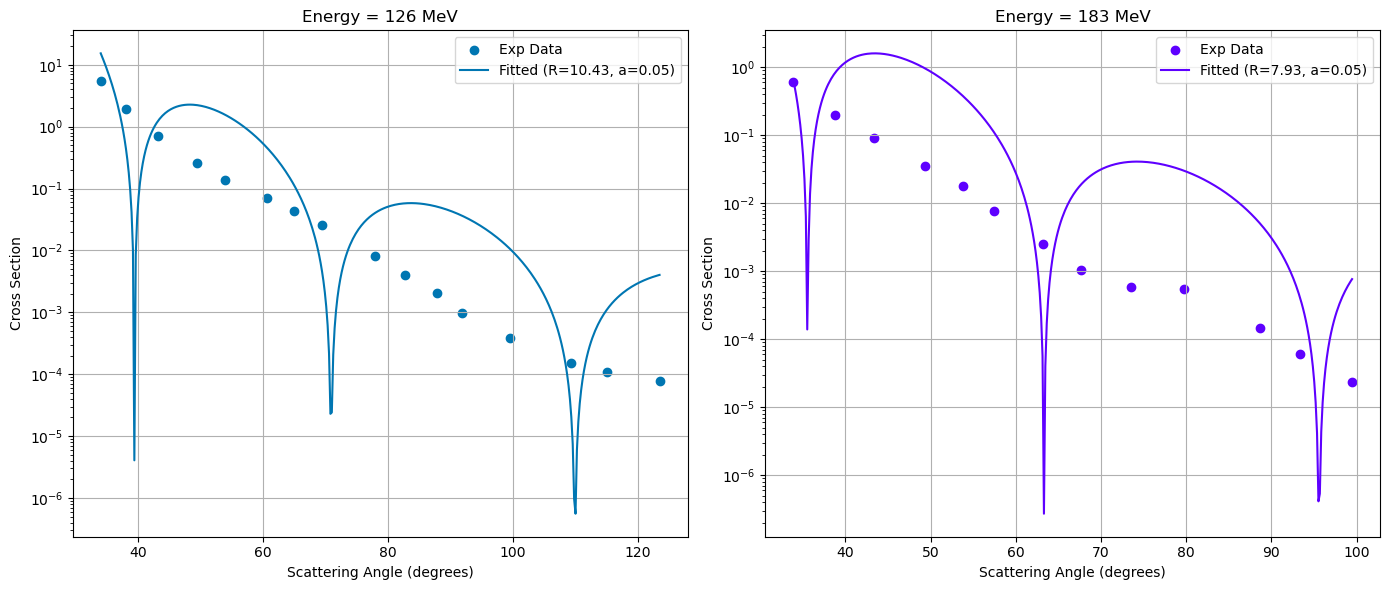

In [68]:
colors = {126: "#0076B2FF", 183: '#5e00ff'}
fig, axs = plt.subplots(1, len(energy_values), figsize=(14, 6))
for i, E in enumerate(energy_values):
    theta_exp_deg = data_by_E[E][0]  
    cs_exp = data_by_E[E][1]

    theta_smooth_deg = np.linspace(min(theta_exp_deg), max(theta_exp_deg), 400)
    theta_smooth_rad = np.radians(theta_smooth_deg)
    R_opt = results[E]['R']
    a_opt = results[E]['a']
    # Calculate smooth fitted curve
    fitted_cs_smooth = [
        calculate_cs_torch(
            torch.tensor([R_opt], dtype=torch.float32),
            torch.tensor([a_opt], dtype=torch.float32),
            torch.tensor([t], dtype=torch.float32),
            E=E
        ).item() for t in theta_smooth_rad
    ]

    axs[i].scatter(theta_exp_deg, cs_exp, color=colors[E], marker='o', label=f'Exp Data')

    axs[i].plot(theta_smooth_deg, fitted_cs_smooth, '-', color=colors[E],
                label=f'Fitted (R={R_opt:.2f}, a={a_opt:.2f})')
    axs[i].set_yscale('log')
    axs[i].set_xlabel("Scattering Angle (degrees)")
    axs[i].set_ylabel("Cross Section")
    axs[i].set_title(f"Energy = {E} MeV")
    axs[i].grid(True)
    axs[i].legend()
plt.tight_layout()
plt.show()